<a href="https://colab.research.google.com/github/Lokaro1/RNN_Stock_Prediction/blob/main/Copy_of_RNN_Workshop%2C_predicting_APL_stock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Make sure to create a copy of the file by clicking on "File" in the top left, and then "Make a Copy"

We will train the data by taking a time interval in the data and then predicting the following day based on that interval. So for example we will take days 1 to 60 and use the data in that interval to predict what the value of the stock is in day 61.  Doing so for all possible intervals will train our model!


In [1]:
# Importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, Input
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed

set_seed(455)
np.random.seed(455)


Loading the dataset

In [2]:
url = "https://raw.githubusercontent.com/Patea4/rnn-workshop/refs/heads/main/AAPL.csv"
dataset = pd.read_csv(url, index_col="Date", parse_dates=["Date"]).drop(["Adj Close"], axis=1)

print(dataset.head())
print(dataset.describe())

                Open      High       Low     Close     Volume
Date                                                         
1980-12-12  0.513393  0.515625  0.513393  0.513393  117258400
1980-12-15  0.488839  0.488839  0.486607  0.486607   43971200
1980-12-16  0.453125  0.453125  0.450893  0.450893   26432000
1980-12-17  0.462054  0.464286  0.462054  0.462054   21610400
1980-12-18  0.475446  0.477679  0.475446  0.475446   18362400
              Open         High          Low        Close        Volume
count  9909.000000  9909.000000  9909.000000  9909.000000  9.909000e+03
mean     32.606849    32.936079    32.277560    32.618030  8.582916e+07
std      58.415759    59.001576    57.883037    58.471899  8.597195e+07
min       0.198661     0.198661     0.196429     0.196429  3.472000e+05
25%       1.071429     1.089286     1.048571     1.071429  3.304230e+07
50%       1.729286     1.758929     1.696429     1.732143  5.766490e+07
75%      35.799999    36.265713    35.328571    35.761429  1.0

In [3]:
print(dataset.isna().sum())

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64


This will generate the graph of the stock price, the blue part is the training set, and the orange part is the validation set.

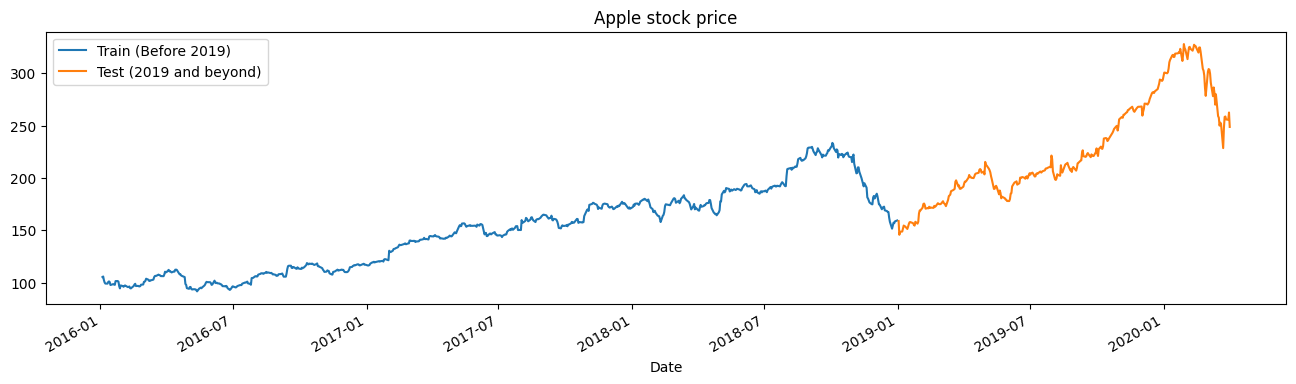

In [4]:
tstart = 2016
tend = 2018
# Considering data from start of 2016 to end of 2018

def train_test_plot(dataset, tstart, tend):
    dataset.loc[f"{tstart}":f"{tend}", "High"].plot(figsize=(16, 4), legend=True)
    dataset.loc[f"{tend+1}":, "High"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title("Apple stock price")
    plt.show()

train_test_plot(dataset,tstart,tend)

In [5]:
def train_test_split(dataset, tstart, tend):
    train = dataset.loc[f"{tstart}":f"{tend}", "High"].values
    test = dataset.loc[f"{tend+1}":, "High"].values
    return train, test

training_set, test_set = train_test_split(dataset, tstart, tend)


In [6]:
sc = MinMaxScaler(feature_range=(0, 1))
training_set = training_set.reshape(-1, 1)
training_set_scaled = sc.fit_transform(training_set)

In [7]:
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    # Creating the training "windows" of n size
    for i in range(len(sequence)):
        end_ix = i + n_steps# what is the last x value? (where x is the ending timestamp of our training window, inclusive)
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)


n_steps = 60
features = 1

X_train, y_train = split_sequence(training_set_scaled, n_steps)


In [8]:
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],features)


Your RNN should be a chain of n_steps LSTM blocks chained together, where each LSTM block takes a 1 dimensional feature vector (stock price) as input

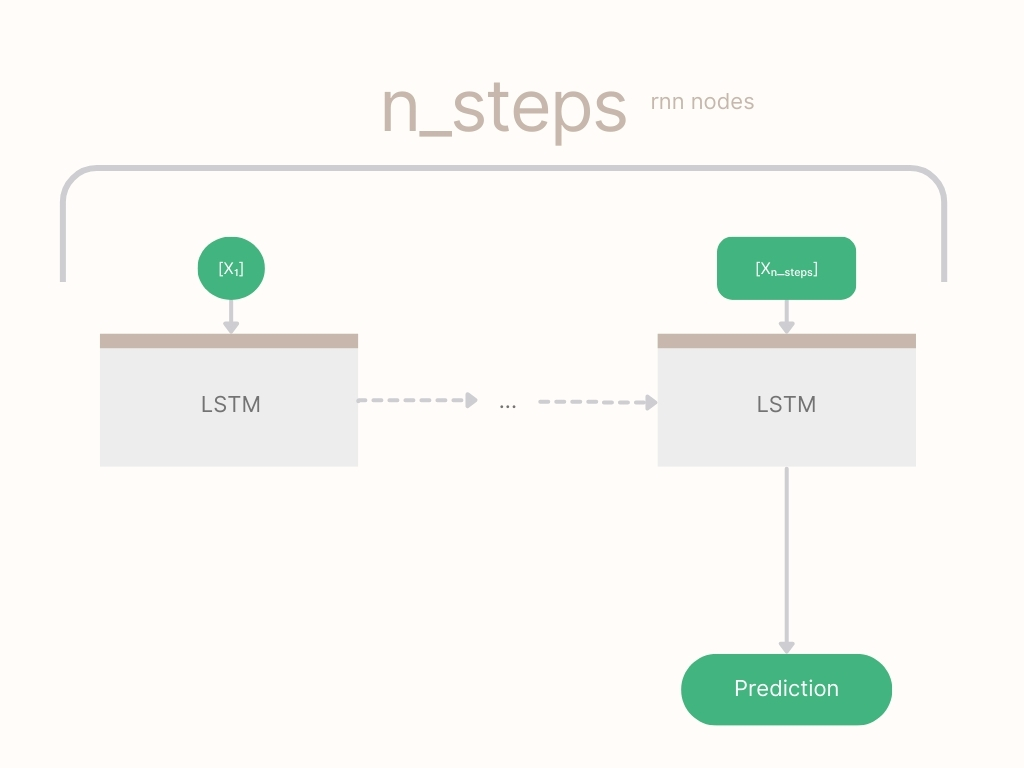

In [10]:
model_lstm = Sequential()
shape = (n_steps, 1)# what should be the input shape be? (hint it's gonna be a two element tuple, the first entry is the number of steps, the second entry is the dimension of each feature)
model_lstm.add(Input(shape=shape))

lstm_layer = LSTM(units=125, activation="tanh")
dense_layer = Dense(units=1)
# How do we add these layers to the model?
model_lstm.add(lstm_layer)
model_lstm.add(dense_layer)

model_lstm.compile(optimizer="RMSprop", loss="mse")

model_lstm.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 125)                 │          63,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             126 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,626 (248.54 KB)

 Trainable params: 63,626 (248.54 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model_lstm.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.0506
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 0.0029
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0031
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0024
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 0.0022
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 105ms/step - loss: 0.0020
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 0.0018
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - loss: 0.0017
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0015
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0014
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - loss: 0.0014
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 0.0013
Epoch 13/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step - loss: 0.0012
Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0012
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - loss: 0.0011
Ep

In [12]:
dataset_total = dataset.loc[:,"High"]
inputs = dataset_total[len(dataset_total) - len(test_set) - n_steps :].values
inputs = inputs.reshape(-1, 1)
#scaling
inputs = sc.transform(inputs)

# Split into samples
X_test, y_test = split_sequence(inputs, n_steps)
# reshape
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], features)
#prediction
predicted_stock_price = model_lstm.predict(X_test)
#inverse transform the values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


In [13]:
def plot_predictions(test, predicted):
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title("Apple Stock Price Prediction")
    plt.xlabel("Time")
    plt.ylabel("Apple Stock Price")
    plt.legend()
    plt.show()


def return_rmse(test, predicted):
    rmse = np.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {:.2f}.".format(rmse))


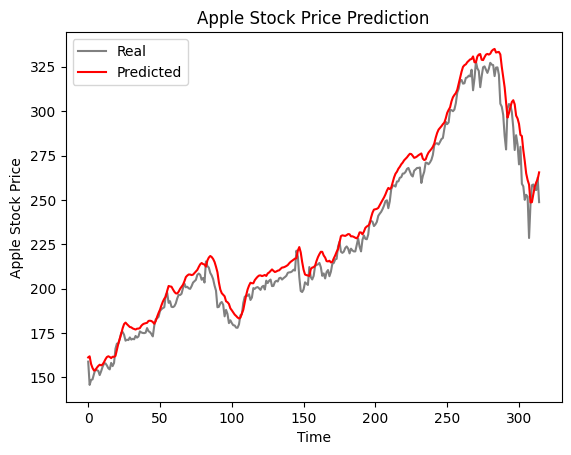

In [14]:
plot_predictions(test_set,predicted_stock_price)

In [15]:
return_rmse(test_set,predicted_stock_price)

The root mean squared error is 8.52.


Now make a RNN model that uses GRU blocks instead of LSTM blocks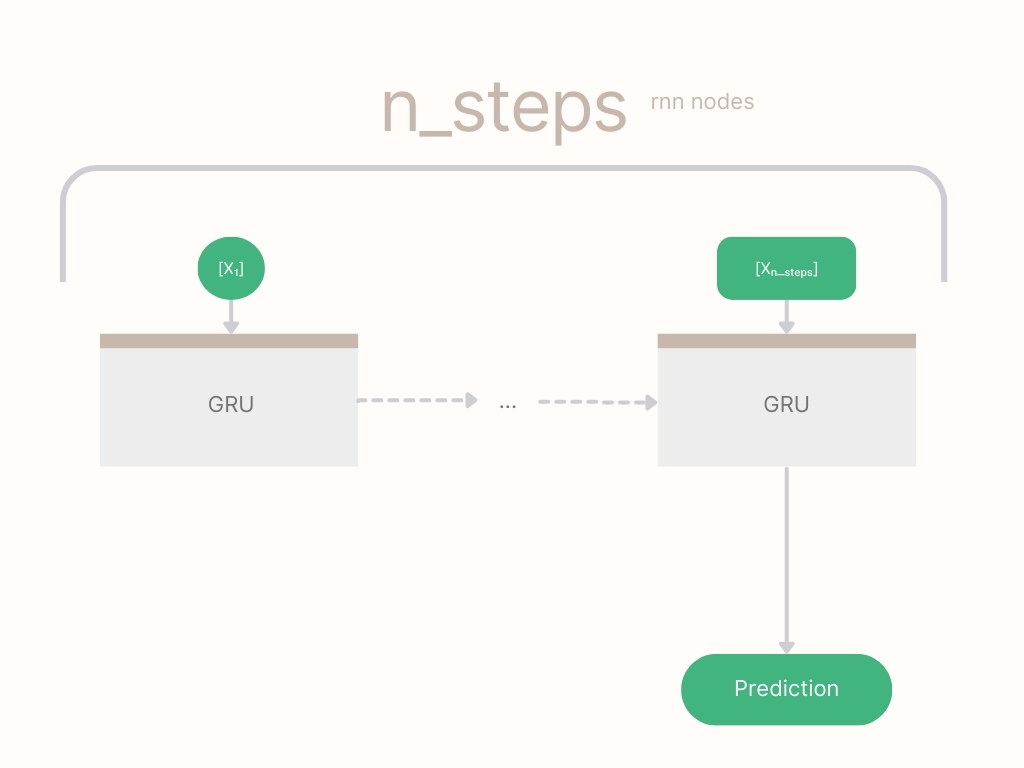

In [17]:
# make an RNN model, this time replacing LSTM with GRU
model_gru = Sequential()
shape = (n_steps, 1)# what should be the input shape be? (hint it's gonna be a two element tuple, the first entry is the number of steps, the second entry is the dimension of each feature)
model_gru.add(Input(shape=shape))

gru_layer = GRU(units=125, activation="tanh")
dense_layer = Dense(units=1)
# How do we add these layers to the model?
model_gru.add(gru_layer)
model_gru.add(dense_layer)

model_gru.compile(optimizer="RMSprop", loss="mse")
model_gru.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 125)                 │          48,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             126 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 48,126 (187.99 KB)

 Trainable params: 48,126 (187.99 KB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model_gru.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.0418
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0028
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0019
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0017
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0015
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0014
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 3s 91ms/step - loss: 0.0013
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step - loss: 0.0012
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0012
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0011
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0010
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 9.9392e-04
Epoch 13/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 9.5261e-04
Epoch 14/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 9.1567e-04
Epoch 15/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 2s 81ms/step - loss:

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


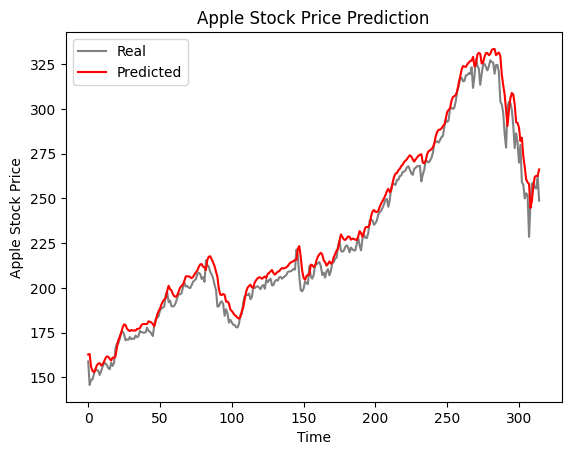

In [19]:
GRU_predicted_stock_price = model_gru.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)
plot_predictions(test_set, GRU_predicted_stock_price)


In [20]:
return_rmse(test_set,GRU_predicted_stock_price)

The root mean squared error is 7.24.
